In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt 
import pennylane as qml
import pennylane.numpy as np 
from main.operators import *
from main.VarQFT import *
from main.circuits import *

np.random.seed(0)

In this notebook we show how to employ our framework to obtain the ground state of a coupled system. We will consider two harmonic oscilator coupled by the Hooke's law. Let $X_j$ and $P_j$ the position and momentum operators of the $j$-th oscilator. The Hamiltonian is
$$ H =  P_1^2 + X_1^2 + P_2^2 + X_2^2 + ( X_1 - X_2)^2  . $$
We omit the factor $1/2$ for simplicity. To create the operator $X_1 - X_2$ we have to use the function ```distance```. We define a number of qubits for each system, and the total one will be the sum of them.

In [2]:
num_wires = 3
dev = qml.device( "lightning.qubit", 
                    wires=2*num_wires, shots=100)

In [3]:
wires1 = range(num_wires)
wires2 = range(num_wires,2*num_wires)

xrange = 5
X1, P1 = X_and_P_ops( range(num_wires), -xrange, xrange )    
X2, P2 = X_and_P_ops( range(num_wires,2*num_wires), -xrange, xrange )    

I1 = qml.Identity(wires1)
I2 = qml.Identity(wires2)

R = 0.25

H2 = [ 
        P1.pow(2),
        P2.pow(2),
        addition( X1, qml.s_prod(-R,I1), abs=True ).pow(-1).s_prod(-1),
        addition( X1, qml.s_prod(R,I1 ), abs=True ).pow(-1).s_prod(-1),
        addition( X2, qml.s_prod(-R,I2), abs=True ).pow(-1).s_prod(-1),
        addition( X2, qml.s_prod(R,I2), abs=True ).pow(-1).s_prod(-1),
        distance( X1, X2 ).pow(-1) 
        ]
H2 

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5]>]

In [5]:
H2_matrix = tomatrix( H2 )

In [6]:
vals, vecs = np.linalg.eigh( H2_matrix )
vec = vecs[:,0]

In [7]:
vals

array([-3.46708790e+00, -3.33897986e+00, -2.84565788e+00, -2.76637036e+00,
       -2.54089476e+00, -2.36438685e+00, -2.03667484e+00, -1.85973995e+00,
       -1.44472059e+00, -1.35324587e+00, -1.22812404e+00, -1.08334410e+00,
       -9.80022875e-01, -9.31606844e-01, -6.34289785e-01, -4.11433775e-01,
       -3.64865634e-01, -2.75837310e-01, -2.71255506e-01, -2.32088998e-01,
        1.78044401e-01,  1.97365892e-01,  4.74507851e-01,  5.85432361e-01,
        6.45525167e-01,  7.99422500e-01,  9.81088256e-01,  1.05948638e+00,
        1.10656225e+00,  1.22727296e+00,  1.31096884e+00,  1.34766727e+00,
        1.54122418e+00,  1.73977114e+00,  1.91927050e+00,  1.93582882e+00,
        2.20957668e+00,  2.29649779e+00,  2.30709347e+00,  2.61004915e+00,
        2.62036544e+00,  2.71230053e+00,  2.94065473e+00,  2.97963401e+00,
        3.23655035e+00,  3.65850322e+00,  3.75176088e+00,  3.84210356e+00,
        3.94151601e+00,  4.32057534e+00,  4.39405034e+00,  4.54427756e+00,
        4.96814901e+00,  

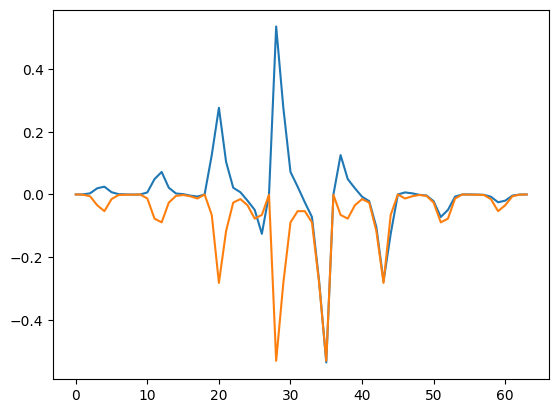

In [20]:
plt.plot( np.real(vecs[:,0]) )
plt.plot( -np.real(vecs[:,1]) )

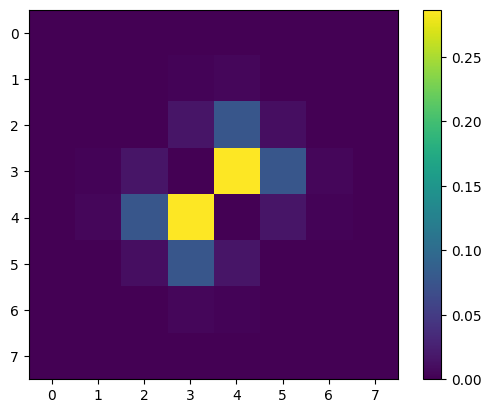

In [9]:
vec_reshape = vec.reshape( 2**num_wires, 2**num_wires )
plt.imshow( np.abs(vec_reshape)**2 )
plt.colorbar()

Obtaining the groud state by ```numpy``` for comparisons.

In [10]:
num_layers = 1
circuit_def = ZGR_ansatz( 2*num_wires - 1, num_layers )
num_params = circuit_def.num_params
params     = 0.001 * np.random.randn(num_params)
var_state  = circuit_def.construct_circuit

circuit_def_sym = symmetric_ansatz(circuit_def, antisymmetric=False)
var_state_sym  = circuit_def_sym.construct_circuit


In [11]:
varqft = VarFourier( H2, 
                    dev, 
                    var_state_sym )

In [12]:
Params, Energies = varqft.run( params , max_iterations=1000, learning_rate=0.1 )

c:\Users\lucia\miniconda3\envs\pennylane\Lib\site-packages\pennylane\_qubit_device.py:551: UserWarning: Requested measurement MyMP with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


Step:    320, Energy:    -2.957058


sym = -3.025295

In [23]:
-3.025295--2.957058

-0.06823699999999988

In [24]:
-3.46708790e+00 - -3.33897986e+00

-0.1281080400000003

In [13]:
# np.save( 'data_sym', np.array([vals,vecs,Params,Energies], dtype=object))

In [14]:
dev = qml.device( "default.qubit", 
                    wires=2*num_wires )

ground_state = varqft.state( Params[-1], dev )

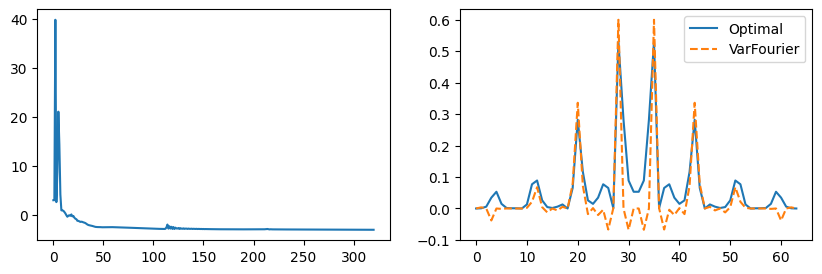

In [22]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( Energies )
# ax[0].hlines( val, 0, len(Energies), colors='tab:red', linestyles='--' )
# ax[1].plot( np.abs(vec)**2) 
plt.plot( np.real(vecs[:,1]) )
ax[1].plot( np.real(ground_state), '--' ) 
ax[1].legend(['Optimal','VarFourier'], loc='best') 
#ax[1].set_ylim([0.0,0.01])

In [16]:
np.abs( vecs.T.conj()@ground_state )

tensor([1.35587146e-14, 8.41377979e-01, 1.80659909e-01, 2.99222193e-01,
        2.11589951e-15, 6.86540712e-15, 2.96962543e-01, 1.91152867e-01,
        2.63852856e-15, 8.00575805e-15, 8.64005076e-14, 4.07485189e-02,
        9.87941103e-02, 1.82658174e-14, 6.00197003e-14, 1.31627983e-01,
        6.80720534e-02, 1.96488909e-15, 1.09558922e-02, 2.96984749e-15,
        4.96020520e-02, 1.10633601e-02, 6.60594184e-02, 1.62491548e-14,
        2.67494707e-15, 1.53117176e-02, 9.70773259e-15, 2.04937010e-02,
        1.35325789e-14, 8.98634023e-16, 3.59174512e-15, 8.97676039e-15,
        1.90993173e-15, 1.23671961e-02, 8.28189319e-03, 1.43533190e-14,
        3.68633426e-02, 2.23372375e-02, 6.89379109e-15, 1.14088564e-02,
        1.11171810e-02, 3.18245925e-15, 2.59204980e-02, 1.21250010e-02,
        9.83588666e-16, 5.45354490e-16, 6.98768345e-15, 5.61680678e-03,
        1.81335987e-16, 7.04052239e-03, 2.86302712e-02, 3.44472718e-15,
        6.02817999e-16, 5.20619090e-04, 1.55041902e-16, 5.508933

In [17]:
psi1 = np.abs(ground_state[0:8])**2
psi2 = np.abs(ground_state[8:15])**2

In [18]:
print(psi2)

[2.02295844e-09 1.78731025e-11 4.68937895e-06 4.54637453e-04
 4.57560612e-03 1.77374538e-05 1.53001217e-04]


[[-5.27518669e-09+0.j  3.65770155e-03+0.j  1.40912132e-07+0.j
  -3.80236332e-02+0.j -2.59435409e-06+0.j -1.24188497e-03+0.j
   1.14242446e-04+0.j  1.76869663e-04+0.j]
 [ 4.49773103e-05+0.j  4.22765923e-06+0.j  2.16549739e-03+0.j
   2.13222291e-02+0.j  6.76432267e-02+0.j  4.21158567e-03+0.j
  -1.23693661e-02+0.j -4.30380580e-05+0.j]
 [-6.09563945e-03+0.j  5.31541123e-03+0.j -5.23106722e-05+0.j
   7.82899224e-02+0.j  3.35799895e-01+0.j  7.23966599e-02+0.j
  -1.77810641e-02+0.j  1.30727432e-03+0.j]
 [-2.07808640e-02+0.j -3.93836839e-03+0.j -6.67893165e-02+0.j
   1.19320532e-03+0.j  5.99448240e-01+0.j  1.83290166e-04+0.j
  -6.76039872e-02+0.j  8.03480200e-06+0.j]
 [ 8.03480200e-06+0.j -6.76039872e-02+0.j  1.83290166e-04+0.j
   5.99448240e-01+0.j  1.19320532e-03+0.j -6.67893165e-02+0.j
  -3.93836839e-03+0.j -2.07808640e-02+0.j]
 [ 1.30727432e-03+0.j -1.77810641e-02+0.j  7.23966599e-02+0.j
   3.35799895e-01+0.j  7.82899224e-02+0.j -5.23106722e-05+0.j
   5.31541123e-03+0.j -6.09563945e-03+0.j

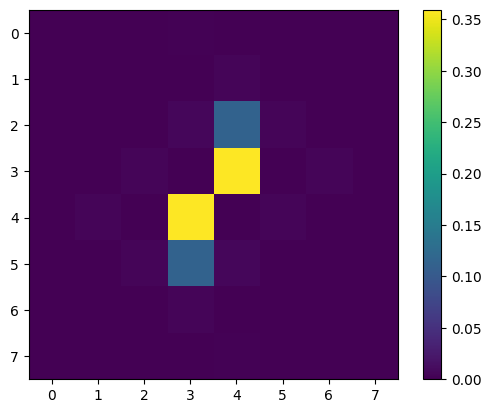

In [19]:
M = ground_state.reshape( 2**num_wires, 2**num_wires )
print(M)
plt.imshow( np.abs(M)**2 )
plt.colorbar()